In [1]:
import cPickle
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

/home/choudhary/installed/anaconda3/envs/vr_project/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Pre-process data

In [ ]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def reshape_img(img):
    img = img.reshape((3,32*32))
    v = np.zeros((32,32,3),dtype=np.uint8)
    for i in range(32):
        for j in range(32):
            v[i][j][0] = img[0][i*32+j]
            v[i][j][1] = img[1][i*32+j]
            v[i][j][2] = img[2][i*32+j]  
    return v


#### Train set

In [ ]:
%%time
DATASET_DIR = "cifar-10-batches-py/"
DATASET_FILES = ["data_batch_1","data_batch_2","data_batch_3","data_batch_4","data_batch_5"]

imgs = []
labels = []

for file in DATASET_FILES:
    data = unpickle(DATASET_DIR + file)
    imgs.extend(data["data"])
    labels.extend(data["labels"])
    
dataset = pd.DataFrame({'img': imgs, 'label': labels})
dataset["img"] = dataset.img.map(reshape_img)
dataset.to_pickle("dataset/train.pkl")

#### Test set

In [ ]:
%%time
DATASET_DIR = "cifar-10-batches-py/"
DATASET_FILES = ["test_batch"]

imgs = []
labels = []

for file in DATASET_FILES:
    data = unpickle(DATASET_DIR + file)
    imgs.extend(data["data"])
    labels.extend(data["labels"])
    
dataset = pd.DataFrame({'img': imgs, 'label': labels})
dataset["img"] = dataset.img.map(reshape_img)
dataset.to_pickle("dataset/test.pkl")

### Load Dataset

In [18]:
DATASET_DIR = "dataset/"
DATASET_FILE = "train.pkl"

# LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
LABELS = ['airplane','automobile','bird','cat','deer','frog','horse','ship','truck']

dataset = pd.read_pickle(DATASET_DIR + DATASET_FILE)
# dataset = dataset.sample(30000,random_state=7)
# dataset = dataset[dataset.label != 3]
dataset = dataset[dataset.label != 5]

SUFFIX = 34

#### Train-Test split

In [19]:
dataset_train, dataset_test = train_test_split(dataset,test_size=.2)

## Method 1: KNN

## Method 2: Linear SVM

In [5]:
import cv2
from skimage.feature import hog
from skimage import color
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#### 1). Using HOG descriptors

In [106]:
%%time
print "Computing descriptors for train set"
X_train = []
for img in dataset_train.img.values:
    X_train.append(hog(color.rgb2gray(img)))
X_train = np.array(X_train)

print "Computing descriptors for test set"
X_test = []
for img in dataset_test.img.values:
    X_test.append(hog(color.rgb2gray(img)))
X_test = np.array(X_test)

y_train = dataset_train.label.values
y_test = dataset_test.label.values

Computing descriptors for train set
Computing descriptors for test set
CPU times: user 21.8 s, sys: 64 ms, total: 21.8 s
Wall time: 21.8 s


#### 2). Using Kmeans clustered BOW

In [ ]:
DICT_SIZE = 100
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=20)

bow_trainer = cv2.BOWKMeansTrainer(DICT_SIZE)
sift = cv2.xfeatures2d.SIFT_create()
# matcher = cv2.FlannBasedMatcher(index_params,search_params)
matcher = cv2.BFMatcher(cv2.NORM_L2)
transformer = cv2.BOWImgDescriptorExtractor(sift,matcher)

##### Compute and dump Vocab

In [ ]:
%%time
for i,row in dataset.iterrows():
    kp, des = sift.detectAndCompute(cv2.cvtColor(row.img,cv2.COLOR_BGR2GRAY),None)
#     kp, des = sift.detectAndCompute(row.img,None)
    if des != None:
        bow_trainer.add(des)
    else:
        print "No features found in image: " + str(i)

print "Clustering features.."
vocab = bow_trainer.cluster()
# cPickle.dump(vocab,file("dataset/vocab.pkl","wb"))

##### Load Vocab

In [ ]:
vocab = cPickle.load(file("dataset/vocab.pkl","r"))

##### Get BOW vectors

In [ ]:
%%time

transformer.setVocabulary(vocab)

print "Computing train set BOW vectors.."
X_train = []
for img in dataset_train.img.values:
    v = transformer.compute(img,sift.detect(img,None))
    if v != None:
        X_train.append(np.array(v[0]))
    else:
        X_train.append(np.zeros(DICT_SIZE))
X_train = np.array(X_train)

print "Computing test set BOW vectors.."
X_test = []
for img in dataset_test.img.values:
    v = transformer.compute(img,sift.detect(img,None))
    if v!= None:
        X_test.append(np.array(v[0]))
    else:
        X_test.append(np.zeros(DICT_SIZE))
X_test = np.array(X_test)

y_train = dataset_train.label.values
y_test = dataset_test.label.values

#### Init and Fit Model

In [107]:
%%time
model = LinearSVC(multi_class='crammer_singer',verbose=1)
# model = SVC(decision_function_shape='ova',kernel='linear',verbose=True)
model.fit(X_train,y_train)

[LibLinear]CPU times: user 14.7 s, sys: 8 ms, total: 14.7 s
Wall time: 14.7 s


#### Evaluate

In [108]:
score = model.score(X_test,y_test)
score

0.55174999999999996

In [109]:
f = open("output/score"+str(SUFFIX)+".txt",'w+')
f.write(str(score))
f.close()

#### Predict

In [110]:
preds = model.predict(X_test)

#### Draw confusion matrix

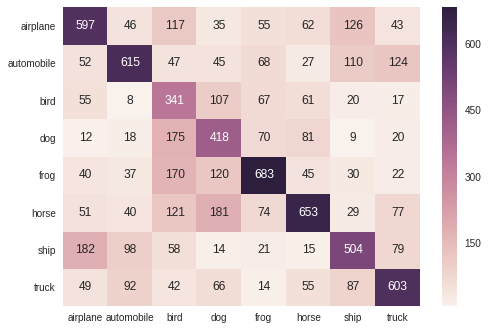

In [111]:
cm = confusion_matrix(preds,y_test)
df_cm = pd.DataFrame(cm, index = LABELS,
                  columns = LABELS)
sn.heatmap(df_cm,annot=True,fmt="")
plt.savefig('output/fig'+str(SUFFIX)+'.png')
plt.show()

## Method 3: CNN

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.constraints import maxnorm
from keras.optimizers import SGD

Using TensorFlow backend.


In [20]:
X_train = []
for v in dataset_train.img.values:
    X_train.append(np.array(v))
X_train = np.array(X_train)

X_test = []
for v in dataset_test.img.values:
    X_test.append(np.array(v))
X_test = np.array(X_test)

y_train = to_categorical(dataset_train.label.values)
y_test = to_categorical(dataset_test.label.values)

#### Compile Model

In [21]:
EPOCHS = 40
L_RATE = 0.01
DECAY = L_RATE/EPOCHS

sgd = SGD(lr=L_RATE, momentum=0.9, decay=DECAY, nesterov=False)

# Create Keras model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu',input_shape=(32,32,3)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(ZeroPadding2D((1, 1)))

model.add(Convolution2D(128, 3, 3, border_mode='valid', activation='relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(128, 3, 3, border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ZeroPadding2D((1, 1)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.summary()

#### Fit

In [22]:
model.fit(X_train, y_train,validation_split=0.2,batch_size=64, nb_epoch=EPOCHS,verbose=1)

Train on 28800 samples, validate on 7200 samples
Epoch 1/40
28800/28800 [==============================] - 287s - loss: 2.2012 - acc: 0.1347 - val_loss: 2.1303 - val_acc: 0.2065

#### Evaluate

In [23]:
score = model.evaluate(X_test, y_test, verbose=1)
score

9000/9000 [==============================] - 34s     

[0.71137954092025757, 0.77033333333333331]

In [24]:
f = open("output/score"+str(SUFFIX)+".txt",'w+')
f.write("Dataset size: %d\n"%(len(dataset)))
f.write("Epochs: %d\n"%(EPOCHS))
f.write(str(score))
f.close()

#### Predict

In [25]:
preds = []
for pred in model.predict(X_test):
    preds.append(pred.argmax())
    
y_test_labels = []
for y in y_test:
    y_test_labels.append(y.argmax())

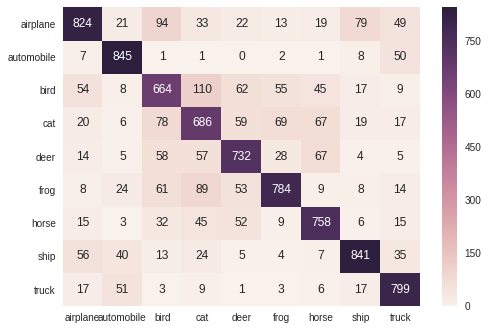

In [26]:
cm = confusion_matrix(preds,y_test_labels)
df_cm = pd.DataFrame(cm, index = LABELS,
                  columns = LABELS)
sn.heatmap(df_cm,annot=True,fmt="")
plt.savefig('output/fig'+str(SUFFIX)+'.png')
plt.show()